In [1]:
import pandas as pd
import polars as pl
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
from math import sqrt
import shap

/Volumes/T7/Projekty/Projekt-Dyplomowy-ISSI-Jan-lusarek-Kacper-Gruca/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet("../../Data/ML_DF/model_df.parquet")
final_df_clean = pl.read_parquet("../../Data/ML_DF/final_df_clean.parquet")

In [12]:
df

,num_males,num_residents,num_children,num_employed,num_with_higher_education,n_rooms,hometype_flat,kettle,dishwasher,microwave,washingmachine,smart_automation_binary,total_power_consumption
0,0,1,0,1,1,8,1,0.004318,0.000069,0.003003,0.000069,0,5.053820
1,0,1,0,1,1,8,1,0.006253,0.000000,0.004005,0.000000,0,4.940298
2,0,1,0,1,1,8,1,0.004502,0.000654,0.000970,0.023732,0,5.315698
3,0,1,0,1,1,8,1,0.007381,0.000008,0.001165,0.022139,0,4.786976
4,0,1,0,1,1,8,1,0.005434,0.000000,0.001619,0.000007,0,3.920567
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623,3,4,2,2,1,11,0,0.004009,0.000000,0.000000,0.092427,1,7.964286
2624,3,4,2,2,1,11,0,0.002437,0.000000,0.000000,0.090654,1,8.823480
2625,3,4,2,2,1,11,0,0.004061,0.002204,0.000000,0.000000,1,9.759838
2626,3,4,2,2,1,11,0,0.002460,0.000000,0.000000,0.000000,1,10.222990


In [19]:
final_df_clean

homeid_1,date,num_males,num_females,num_residents,num_children,num_employed,num_with_higher_education,daily_standing_charge_pence,unit_charge_pence_per_kwh,n_rooms,hometype_flat,kettle,dishwasher,microwave,washingmachine,smart_automation_binary,total_power_consumption
i64,date,i64,i64,i64,i64,i64,i64,f64,f64,i64,u8,f64,f64,f64,f64,i8,f64
105,2017-05-18,0,1,1,0,1,1,14.0,13.32,8,1,0.004318,0.000069,0.003003,0.000069,0,5.05382
105,2017-05-19,0,1,1,0,1,1,14.0,13.32,8,1,0.006253,0.0,0.004005,0.0,0,4.940298
105,2017-05-20,0,1,1,0,1,1,14.0,13.32,8,1,0.004502,0.000654,0.00097,0.023732,0,5.315698
105,2017-05-21,0,1,1,0,1,1,14.0,13.32,8,1,0.007381,0.000008,0.001165,0.022139,0,4.786976
105,2017-05-22,0,1,1,0,1,1,14.0,13.32,8,1,0.005434,0.0,0.001619,0.000007,0,3.920567
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
264,2018-06-26,3,1,4,2,2,1,25.0,12.53,11,0,0.004009,0.0,0.0,0.092427,1,7.964286
264,2018-06-27,3,1,4,2,2,1,25.0,12.53,11,0,0.002437,0.0,0.0,0.090654,1,8.82348
264,2018-06-28,3,1,4,2,2,1,25.0,12.53,11,0,0.004061,0.002204,0.0,0.0,1,9.759838


In [17]:
final_df_clean.columns

['homeid_1',
 'date',
 'num_males',
 'num_females',
 'num_residents',
 'num_children',
 'num_employed',
 'num_with_higher_education',
 'daily_standing_charge_pence',
 'unit_charge_pence_per_kwh',
 'n_rooms',
 'hometype_flat',
 'kettle',
 'dishwasher',
 'microwave',
 'washingmachine',
 'smart_automation_binary',
 'total_power_consumption']

In [ ]:
# Przygotowanie danych
X = df.drop(columns='total_power_consumption')
y = df['total_power_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7,10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

model = xgb.XGBRegressor(random_state=42)
cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Szukanie najlepszych parametrów
grid_search.fit(X_train, y_train)

# Najlepszy model
best_model = grid_search.best_estimator_

# Ewaluacja
y_pred = best_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))

# Wyniki
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"RMSE na zbiorze testowym: {rmse:.4f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Najlepsze parametry: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
RMSE na zbiorze testowym: 0.2137


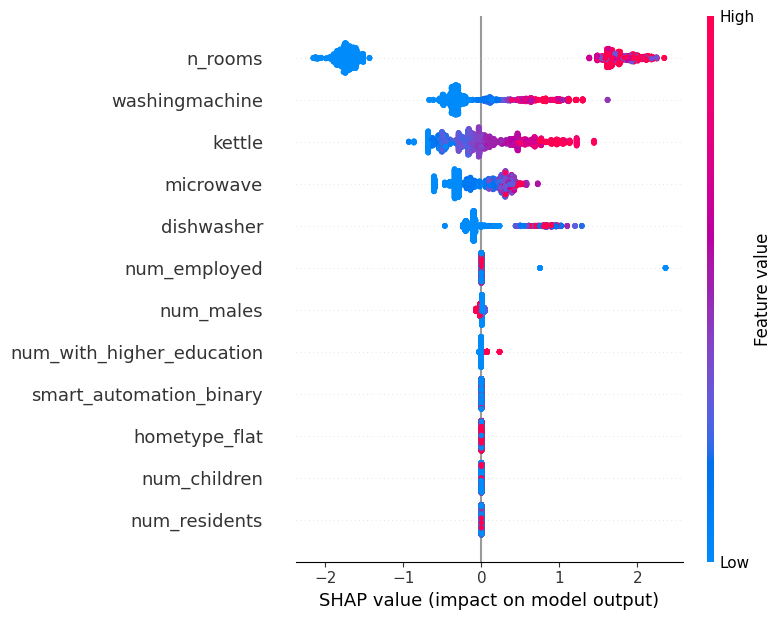

In [11]:
# Przygotowanie danych
X = df.drop(columns='total_power_consumption')
y = df['total_power_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trenowanie modelu
model = xgb.XGBRegressor(n_estimators=20, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Obiekt explainer SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# Wykres: wpływ cech (SHAP summary plot)
shap.summary_plot(shap_values, X_train)